# Data Collection

For this part, you can view another notebook, which includes the detail of how to scrap the data from nba website. I use selenium (for static website) and Beautifulsoup (for dynamic website produced by Javascript) simultaneously.

# Preprocessing

## Outliers
For outliers, we cannot image any possible outliers in All NBA Team. It is selected by coaches based on their performance in this season. None of them can be selected with low attendance of games or bad performance.

But for not All NBA Team players, we need to notice there are lots of players who didn't play much in a season because of injury or ability. Since the number of All NBA Team players is much larger than the number of not All NBA Team players, we can drop these players out to avoid extreme value in game statistics and reduce the imbalance of target label.

## Adjust the traditional statistics

For traditional statistics, we need to notice that the trend of NBA is changing by time and hence the traditional statistics should not be compared without adjusting them. 

To understand this, the background of current NBA offense trend is essential. Previously, teams were inclined to slow down their pace and play half-court offense and defense.  However, this trend was destroyed by Coach Mike D'Antoni in 2004-2005 season. Under the lead of 2-times MVP player Steve Nash, Phoenix Suns started to squeeze their offensive time into 7 seconds or less and accelerate the offensive pace. From that on, teams tried to play quicker and shoot more 3 point balls. After 2010-2011 season, this new trend was gradually expanded. As a result, the current traditional statistics tend to look much better than the previous statistics, due to the increase of pace and possessions.

**In terms of generalization, we preprocess the traditional statistics by dividing them by the average pace of the season.**

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('ALL_NBA_TEAM_train.csv')
test_data = pd.read_csv('ALL_NBA_TEAM_test.csv')
test_data.iloc[91, -2] = 1
test_data.iloc[391, -2] = 1
test_data.iloc[391, -1] = 1
train_data.iloc[11033, -2] = 1

def pace_adjust(row):
    pts = row['PTS'] / row['Avg Pace']
    reb = row['REB'] / row['Avg Pace']
    ast = row['AST'] / row['Avg Pace']
    tov = row['TOV'] / row['Avg Pace']
    stl = row['STL'] / row['Avg Pace']
    blk = row['BLK'] / row['Avg Pace']
    fgm = row['FGM'] / row['Avg Pace']
    
    return pts, reb, ast, tov, stl, blk, fgm

# Adjust some statistics with the pace
train_data['PTS'], train_data['REB'], train_data['AST'], train_data['TOV'], \
train_data['STL'], train_data['BLK'], train_data['FGM'] = zip(*train_data.apply(pace_adjust, axis = 1))

test_data['PTS'], test_data['REB'], test_data['AST'], test_data['TOV'], \
test_data['STL'], test_data['BLK'], test_data['FGM'] = zip(*test_data.apply(pace_adjust, axis = 1))

train_data.drop(train_data[train_data.GP < 30].index, inplace = True)

# Feature Selection

To eliminate the number of features (over 30), we select several features for model construction. Some of these features may not appear in our final model, but we keep it here now for completeness and they will be attempted in initial model construction.

These are the features selected to construct the model:

- Adjusted PTS (points)
- Adjusted REB (rebounds)
- Adjusted AST (assists)
- Adjusted TOV (turnover)
- Adjusted STL (steal)
- Adjusted BLK (block)
- Rank 
- **(delete)** Min (minutes played)
- FGM (Field goals made)
- DD2 (Double Double in the season)
- NETRTG (net rating)
- USG% (usage rate)
- PIE (player impact estimator)
- +/- (plus minus stats)
- Selected Last Year? 

In [2]:
selected_features = ['PTS', 'REB', 'AST', 'TOV', 'STL', 'BLK', 
                     'Rank', 'FGM', 'DD2',
                     'NETRTG', 'USG%', 'PIE', '+/-', 'Selected Last Year?']

features_full = ['PTS', 'REB', 'AST', 'TOV', 'STL', 'BLK', 
                     'Rank', 'TS%', 'USG%', 'PIE', 'Selected Last Year?']

X_train = train_data[selected_features]
y_train = train_data['Selected?']
X_test = test_data[selected_features]
y_test = test_data['Selected?']

# Exploratory Data Analysis 

Before we apply machine learning algorithm, it is important to understand features in our data and the relationship between these features.

First, I want to see the difference between distributions of different features for All NBA Team players and not All NBA Team Players. The tool I use is *violinplot* in *seaborn*, which plots the kernel density distribution.

After ignoring some features that are definitely having different distribution between two groups, we draw 7 violinplots.

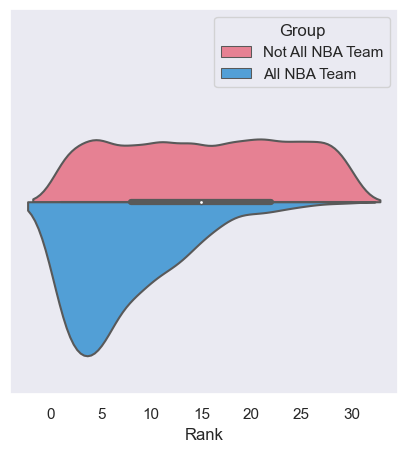

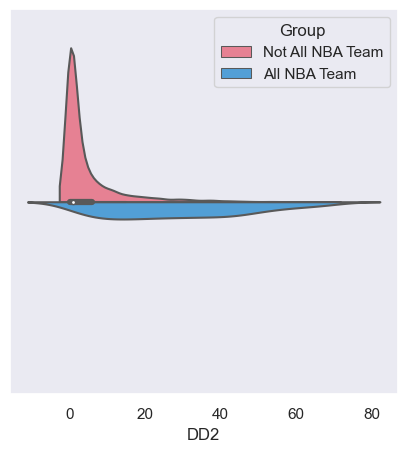

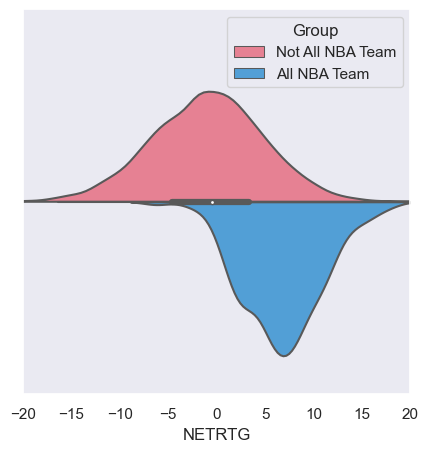

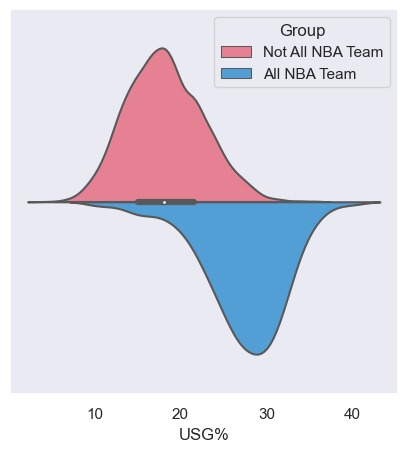

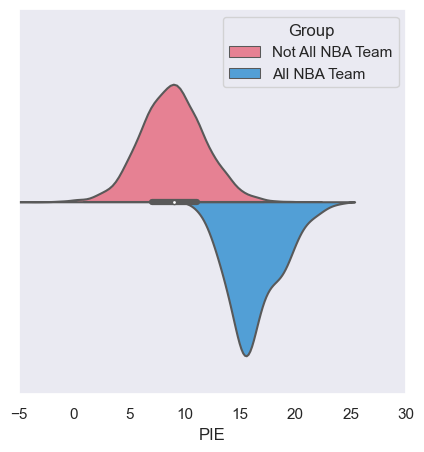

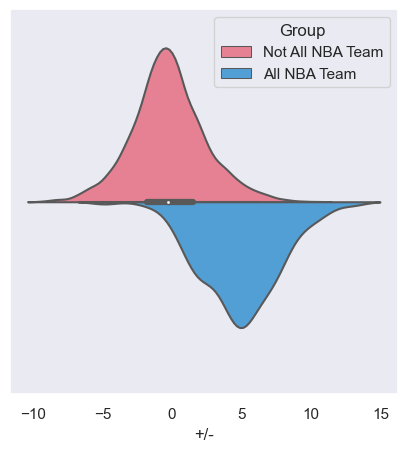

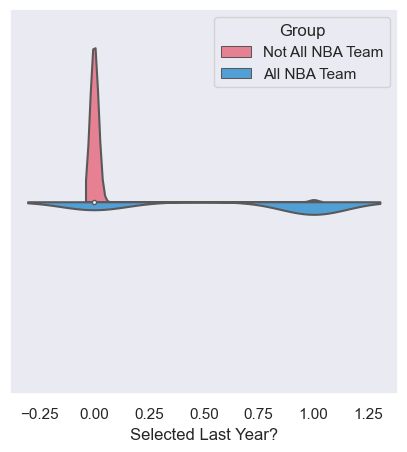

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

husl = sns.color_palette('husl')
# 0 = non all-star: red
# 1 = all-star: green
palette = {
    0 : husl[0],
    1 : husl[4]
}

plt.style.use('default')
sns.set(style = 'dark')
plt.rcParams['legend.title_fontsize'] = 'medium'


size = train_data.shape[0]
features = ['Rank', 'DD2', 'NETRTG', 'USG%', 'PIE', '+/-', 'Selected Last Year?']
for feat in features:
    fig, ax = plt.subplots(figsize = (5, 5))
    
    if feat == 'PIE':
        ax.set_xlim([-5, 30])
        
    if feat == 'NETRTG':
        ax.set_xlim([-20, 20])
        
    sns.violinplot(ax = ax, data = train_data, x = feat, y = [''] * size, hue = 'Selected?', split = True, palette = palette)
    ax.legend_.set_title('Group')
    new_legend = ['Not All NBA Team', 'All NBA Team']
    for t, l in zip(ax.legend_.texts, new_legend):
        t.set_text(l)
    plt.show()

Then we can use *pairplot* in *seaborn* to observe the interaction between features.

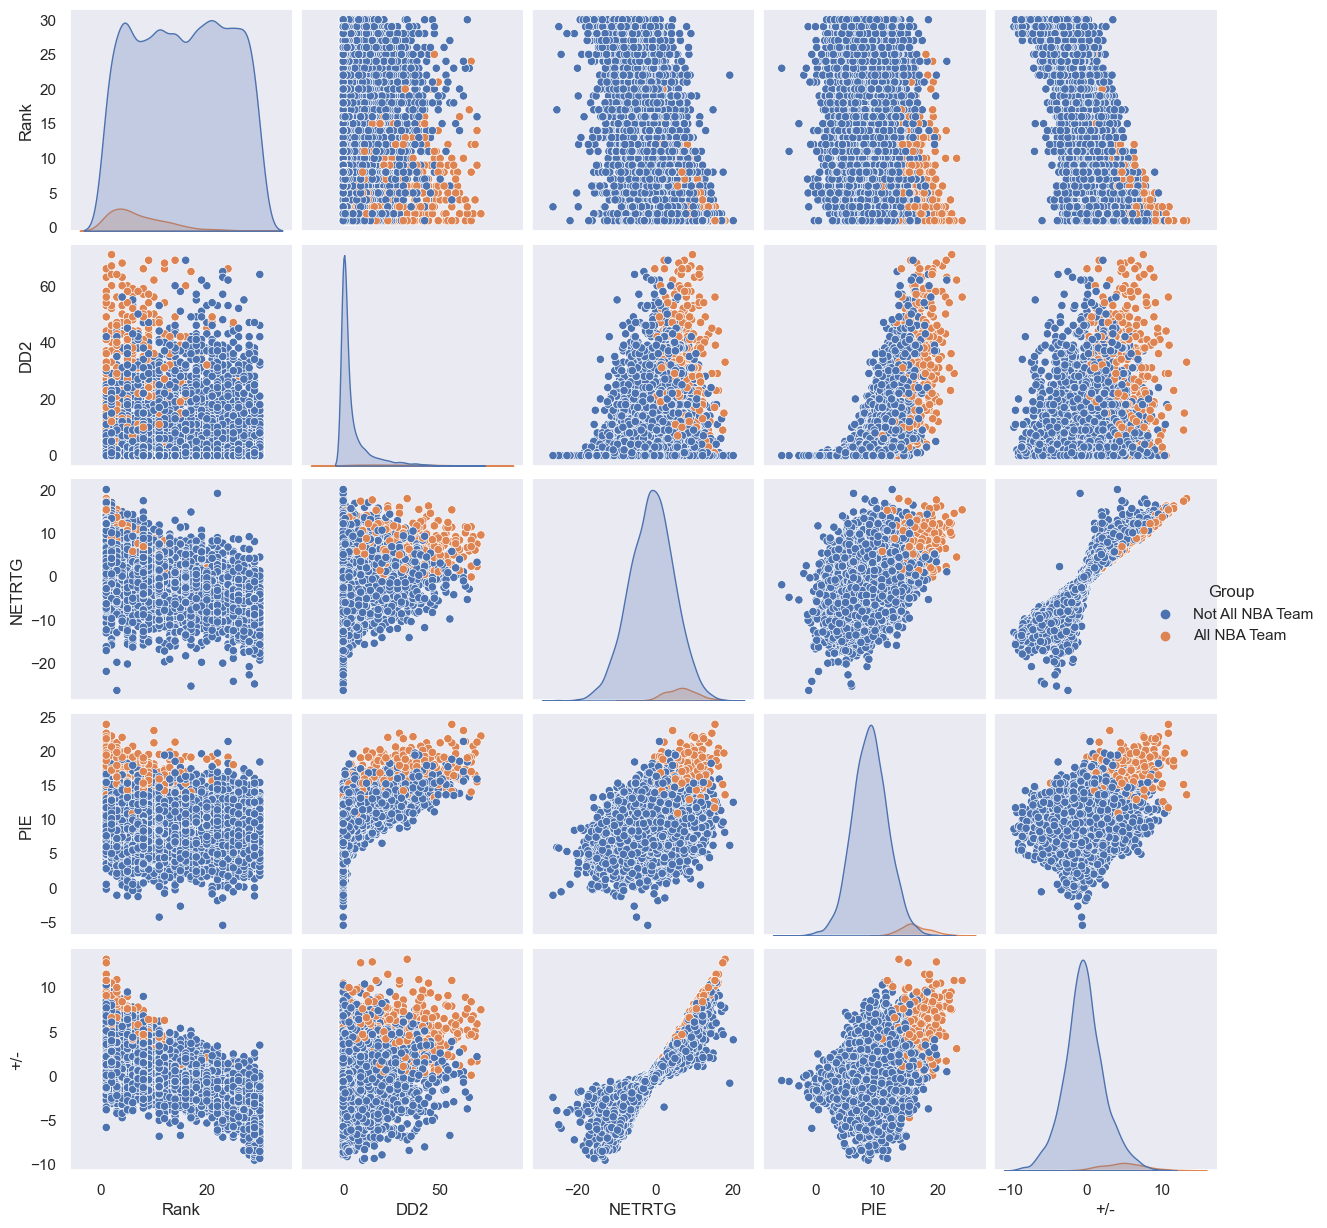

In [67]:
features = ['Rank', 'DD2', 'NETRTG', 'PIE', '+/-', 'Selected?']
ax = sns.pairplot(train_data[features], hue = 'Selected?')

ax._legend.set_title('Group')
new_legend = ['Not All NBA Team', 'All NBA Team']
for t, l in zip(ax._legend.texts, new_legend):
    t.set_text(l)
plt.show()

Unfortunately, it is hard to observe any obvious decision boundary between two groups. 

Finally, we can try **PCA** to observe whether it is possible to classify these two groups.

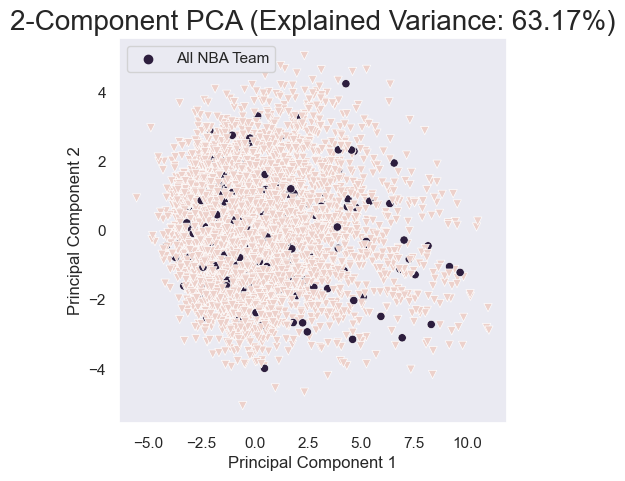

In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(train_data[selected_features])

pca = PCA(n_components = 2)
components = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data = components, columns = ['Principal Component 1', 'Principal Component 2'])
df_pca['Group'] = y_train

fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(data = df_pca, x = 'Principal Component 1', y = 'Principal Component 2', hue = 'Group',
                markers = ['v', 'o'], style = 'Group')

explained_variance = 100 * sum(pca.explained_variance_ratio_)
ax.set_title('2-Component PCA (Explained Variance: {:.2f}%)'.format(explained_variance),
             size=20)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['All NBA Team', 'Not All NBA Team'])
plt.show()

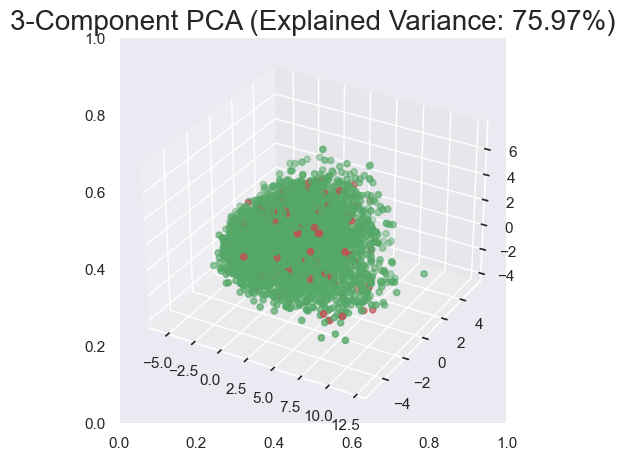

In [69]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(train_data[selected_features])

pca = PCA(n_components = 3)
components = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data = components, columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
df_pca['Group'] = y_train

fig, ax = plt.subplots(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')

colors = np.where(df_pca["Group"]==1,'r','g')

ax.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_pca['Principal Component 3'], 
          c = colors)

explained_variance = 100 * sum(pca.explained_variance_ratio_)
ax.set_title('3-Component PCA (Explained Variance: {:.2f}%)'.format(explained_variance),
             size=20)
plt.show()

It is hard to observe pattern between groups. These may be caused by the existence of inessential features or other reasons. 

As a reminder, the result of PCA only represents that the dataset is not suitable for using PCA, it doesn't mean that these two groups are unable to be classified.

# Modeling

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data[selected_features], 
                                                      train_data['Selected?'], 
                                                      test_size = 0.3,
                                                      random_state = 2)

## Problem: Imbalanced dataset

In [71]:
num_minor_class = y_train.sum()
num_major_class = y_train.count() - y_train.sum()
num_train = y_train.count()

num_major_class, num_minor_class, num_major_class / num_train * 100

(5760, 258, 95.71286141575274)

When dealing with classification problem, one problem is **the balance of classes**. If the classes are imbalanced, the model will develop an inherent bias towards the majority class, which we definitely want to avoid.

In our training set, we have 257 All NBA Team players and 5761 non All NBA Team players. Even if we label every player as an All NBA Team player, we still achieve 95.73% accuracy. Therefore, we need to balance these two classes in order to train a unbiased model.

We have three options:
1. undersample the majority class (drop data points)
2. oversample the minority class 
3. combination of option 1 and 2.

Option 2 is the one we choose. For option 2, we can simply random sampling the attributes from instances in the minority class.  However, the non-linear relationships between the attributes may not be preserved.

There is another choice, **SMOTE** (Synthetic Monority Over-sampling Technique), generating new minority class data by creating synthetic data points.

The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances. 

I select ***BorderlineSMOTE*** from ***imblearn*** library to oversample the class. This method samples near of the border of the optimal decision function to synthesize new data points.

In [72]:
from imblearn.over_sampling import BorderlineSMOTE

X_train_oversampled, y_train_oversampled = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

y_train_oversampled.sum(), y_train_oversampled.count()

(5760, 11520)

In general, decision tree based algorithm are more suitable for tabular/unstructured data, while neural networks are more suitable for unstructured data. 

Since this dataset is tabular and doesn't require complicated probability calculations, we will experiment several popular decision tree based algorithms and select one model among them.

## Model: LightGBM

The decision tree based algorithm that we will call is LightGBM, a popular implementation of gradeint boosted decision tree. There are several hyperparameters that will control the learning process, such as learning rate and maximum tree depth. We will apply a grid search to find the optimal setup, and use early stopping with patience parameter 10 for the sake of avoid overfitting. 

As for evaluation metric, we use **AUC score**. AUC is an evaluation  metric for binary classification problem. It means area under curve, specifically the ROC curve. The ROC compares TPR (true positive rate) and FPR (false positive rate) at different threshold, illustrating a classifier's diagnostic ability at different levels of discrimination. AUC has a value between 0 and 1, which we will expect to achieve an AUC as close to 1 as possible.

**In conclusion, our training process is following:**
1. Select one learning rate without replacement.
2. Train LightGBM using this learning rate.
3. Stop when validation AUC score doesn't improve after 10 epochs. 
4. Record the learning rate with its highest AUC in this round.
5. Return to Step 1.

In [73]:
# Parameters for model
learning_rates = np.arange(10**(-2), 1, 10**(-2)).tolist()
n_estimators_list = np.arange(500, 2100, 100).tolist()
max_depth = 2

# Parameters for training the model
eval_metric = ['error', 'auc']
eval_set = [(X_valid, y_valid)]
early_stopping_rounds = 10

best_learning_rate, best_n_estimator = learning_rates[0], n_estimators_list[0]
highest_auc = -float('inf')

In [ ]:
import lightgbm as lgbm
import pickle

for learning_rate in learning_rates:
    for n_estimator in n_estimators_list:
        model = lgbm.LGBMClassifier(max_depth = max_depth, learning_rate = learning_rate, 
                                    n_estimators = n_estimator, random_state = 0)
        model.fit(X = X_train_oversampled, y = y_train_oversampled, eval_metric = eval_metric, 
                  eval_set = eval_set, early_stopping_rounds = early_stopping_rounds, verbose = True)
        
        curr_auc = max(model.evals_result_['valid_0']['auc'])
        if curr_auc > highest_auc:
            highest_auc, best_learning_rate, best_n_estimator = curr_auc, learning_rate, n_estimator

In [ ]:
# highest_auc = 0.99128, best_learning_rate = 0.62, best_n_estimator = 500

# To plot our training process, we need the training example itself as one of eval sets
eval_set = [(X_train_oversampled, y_train_oversampled), (X_valid, y_valid)]

selected_model = lgbm.LGBMClassifier(max_depth = 2, 
                                  learning_rate = best_learning_rate, 
                                  n_estiamtors = best_n_estimator, random_state = 1)
selected_model.fit(X = X_train_oversampled, y = y_train_oversampled, eval_metric = eval_metric, 
                eval_set = eval_set, early_stopping_rounds = 20, verbose = True)

pickle.dump(selected_model, open('A_NBA_Team_predictor.model', 'wb'))

In [78]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, plot_confusion_matrix
import matplotlib.pyplot as plt

selected_model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))

y_test_proba = [prob[1] for prob in selected_model.predict_proba(X_test)]

def plot_evaluations():
    training_errors = selected_model.evals_result_['training']['binary_error']
    training_aucs = selected_model.evals_result_['training']['auc']
    val_errors = selected_model.evals_result_['valid_1']['binary_error']
    val_aucs = selected_model.evals_result_['valid_1']['auc']
    n_epochs = range(0, len(training_errors))

    ax, fig = plt.subplots(figsize = (5, 5))
    fig.plot(n_epochs, training_aucs, label = 'Training')
    fig.plot(n_epochs, val_aucs, label = 'Validation')
    plt.title('LightGBM AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    ax.legend(loc = 'center right')
    
    ax, fig = plt.subplots(figsize = (5, 5))
    fig.plot(n_epochs, training_errors, label = 'Training')
    fig.plot(n_epochs, val_errors, label = 'Validation')
    plt.title('LightGBM Training Errors')
    plt.xlabel('Epochs')
    plt.ylabel('Err')
    ax.legend(loc = 'upper right')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,8))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    no_skill = [0] * len(y_test)
    fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test, no_skill)
    ax.plot(fpr, tpr, label='XGBoost')
    ax.plot(fpr_ns, tpr_ns, linestyle='--', label='No Skill')
    plt.title('LightGBM Receiver Operating Characteristic\n(AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend()
    plt.show()
    
    plt.style.use('default')
    plt.style.use('seaborn-deep')

    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(selected_model, X_test, y_test, display_labels=['Not AS', 'All Star'], normalize='true', ax=ax)
    plt.title('Normalized confusion matrix\n')
    plt.show()
    
def show_classification_metrics():

    # range of classification thresholds to consider
    thresholds = np.arange(0.1, 1, 0.0025)

    highest_f1_score = -float('inf')
    optimal_threshold = thresholds[0]
    
    for threshold in thresholds:
        y_pred = [0 if prob < threshold else 1 for prob in y_test_proba]
        curr_f1_score = f1_score(y_test, y_pred)
        if curr_f1_score > highest_f1_score:
            highest_f1_score = curr_f1_score
            optimal_threshold = threshold
    print('Optimal threshold: {}'.format(optimal_threshold))
        
    # our binary-forced predictions based upon our F1-score-optimized threshhold
    y_pred = [0 if prob < optimal_threshold else 1 for prob in y_test_proba]

    metrics = [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'Log. Loss',
        'ROC AUC'
    ]

    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        log_loss(y_test, y_test_proba),
        roc_auc_score(y_test, y_test_proba)
    ]

    df_classification_metrics = pd.DataFrame({'Metric' : metrics, 'Score' : scores}).set_index('Metric')

    return df_classification_metrics

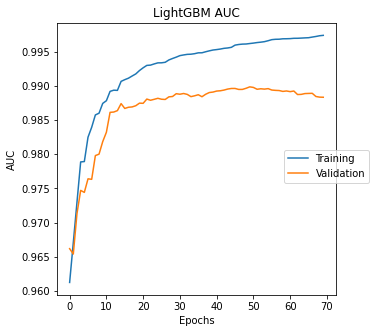

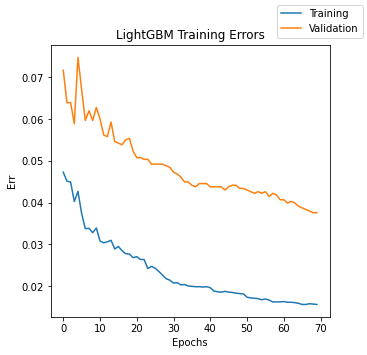

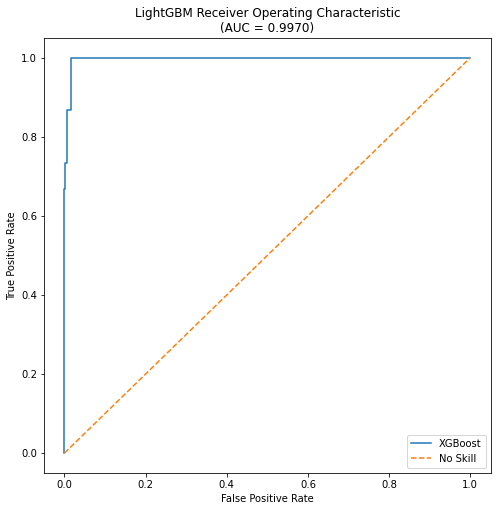

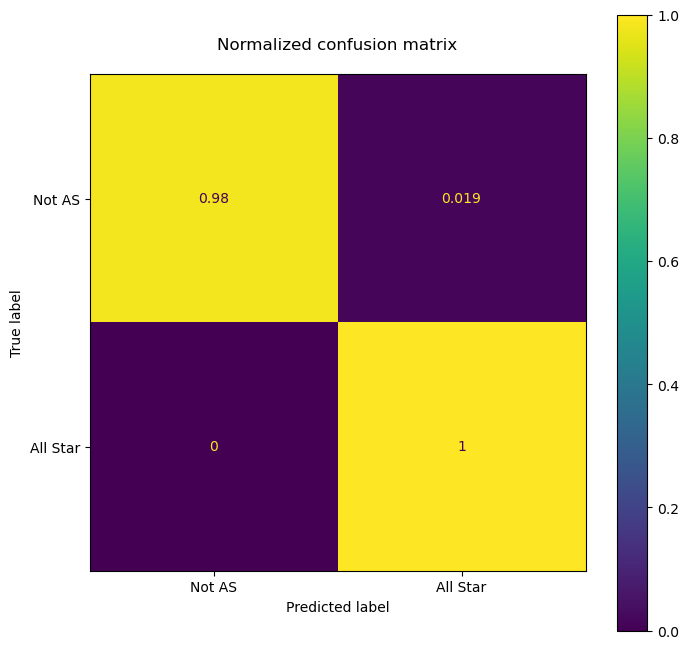

In [39]:
plot_evaluations()

In [79]:
show_classification_metrics()

Optimal threshold: 0.9400000000000007


,Score
Metric,
Accuracy,0.992439
Precision,0.866667
Recall,0.866667
F1 Score,0.866667
Log. Loss,0.065283
ROC AUC,0.997665


Here we can see the evaluation metrics of the model. It has an accuracy of 99% and 86.7% F1 score.

## How well did we actually do?

In [210]:
test_data['proba'] = y_test_proba
top_20_pred = test_data.sort_values(by = 'proba', ascending = False)
top_20_list = ((top_20_pred.iloc[:20, ])[["PLAYER", "TEAM", "proba", "Selected?"]]).set_index('PLAYER')

In [211]:
top_20_list

,TEAM,proba,Selected?
PLAYER,,,
Giannis Antetokounmpo,MIL,0.998106,1
James Harden,HOU,0.994202,1
LeBron James,LAL,0.993080,1
Luka Doncic,DAL,0.990370,1
Anthony Davis,LAL,0.989547,1
Russell Westbrook,HOU,0.988831,1
Kawhi Leonard,LAC,0.988685,1
Damian Lillard,POR,0.985200,1
Jayson Tatum,BOS,0.977097,1


If we pick out the top 15 predictions, we can see that our accuracy is $13/15 = 86.7\%$. It is good, considering that the probabilities are actually close to each other. Besides, the only two mistakes (Chris Paul and Ben Simmons) are still having high probability.

# Model Interpretation

We have a model we're satisfied with. But so far, the entire model is still mystery. We can observe the final output probabilities, but why the model is actually working like this? 

Why Giannis, a recently famous player (two-time MVP owner), is not predicted as one of All-NBA Team members? Why Chirs Paul, a 7-time All-NBA Team member, is only predicted to have 62% probability of being selected?

By nature, some models are easy to interpret by coefficients of parameters or visualization. However, with some complex model, like LightGBM, it is not that straightforward. However, we still have some well-developed techniques to estimate the impact of each feature in complex models. 

The one we will use here is **SHAP** (Shapley Additive explanations). Specifically, we'll use *TreeShap*, a variant of tree-based machine learning models.

We will supplement SHAP analysis with PDP (partial dependency plots) to see how exactly different features alter predictions when we hold other input constant. Both SHAP and PDP are tools to interpret machine learning models.

In [3]:
import shap

def plot_model_bar():
    model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[0], X_test, plot_type = 'bar', show = False)

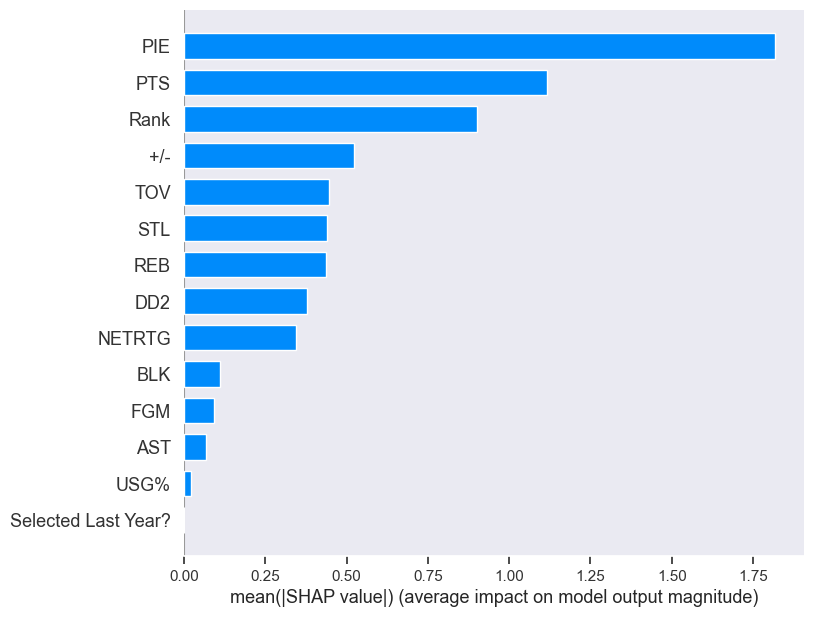

In [87]:
plot_model_bar()

Not surprisingly, **PIE** (Player Impact Estimator) has a high impact on the predictions. The following two are **Points** and **Rank** values.

Points is resonably considered as the most powerful personal statistic, so it is understandable to be at the second place. However, rank is an interesting standard. 

To NBA fans, it is not secret that every year we can list out many players having outstanding statistics, but couldn't help their teams win the ticket of the playoff. Atlanta Hawks player Trae Young is a good recent example. Typically, this type of players won't be recognized by coaches as a star, unless they figure out the way to lead their team. This is why **Rank** could be in such an influential position.

In [156]:
def plot_model_dot():
    model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    shap.summary_plot(shap_values[0], X_test, plot_type = 'dot')

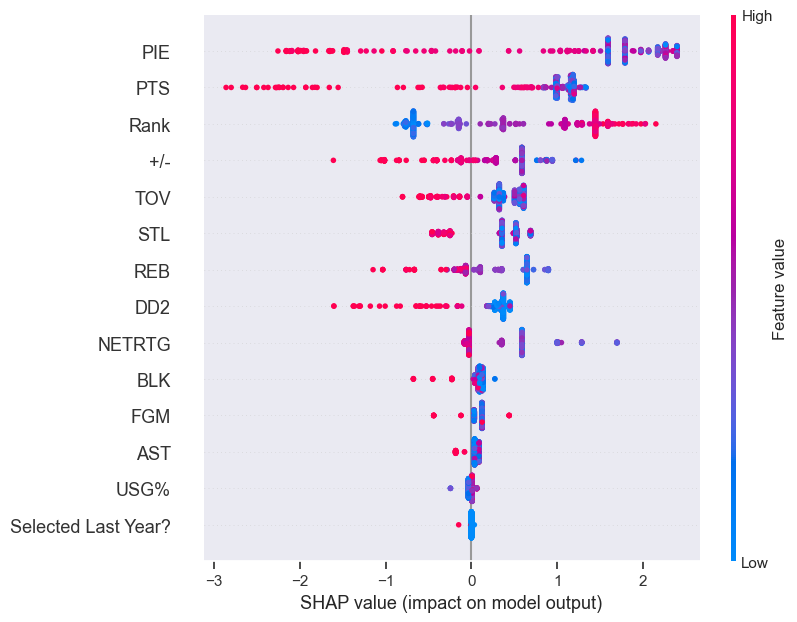

In [157]:
plot_model_dot()

This dot plot has similar effect as the bar plot. Each player in the testing dataset adds one dot to every row in this plot. The color of the dot denotes whether the player's attribute was high or low, and the lateral position is how impactful this attribute value was on the predicted probability.

In [154]:
from pdpbox import pdp

def plot_pdp():
    partial_dependence_features = ['PIE', 'Rank', 'PTS']
    for i, feature in enumerate(partial_dependence_features):
        pdp_feature = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns.tolist(), feature=feature)
        fig, ax = pdp.pdp_plot(pdp_feature, feature, figsize=(10,8))
        plt.show()

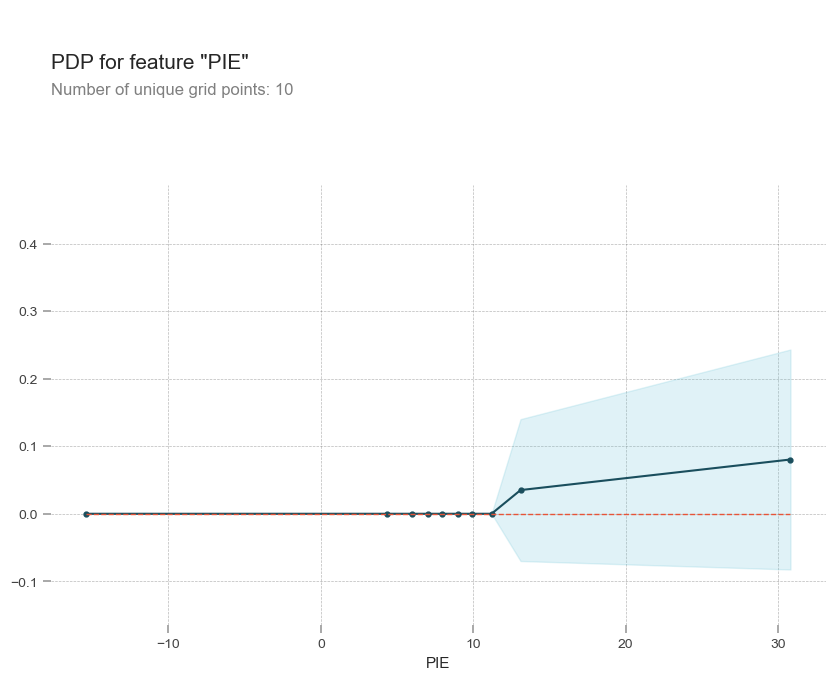

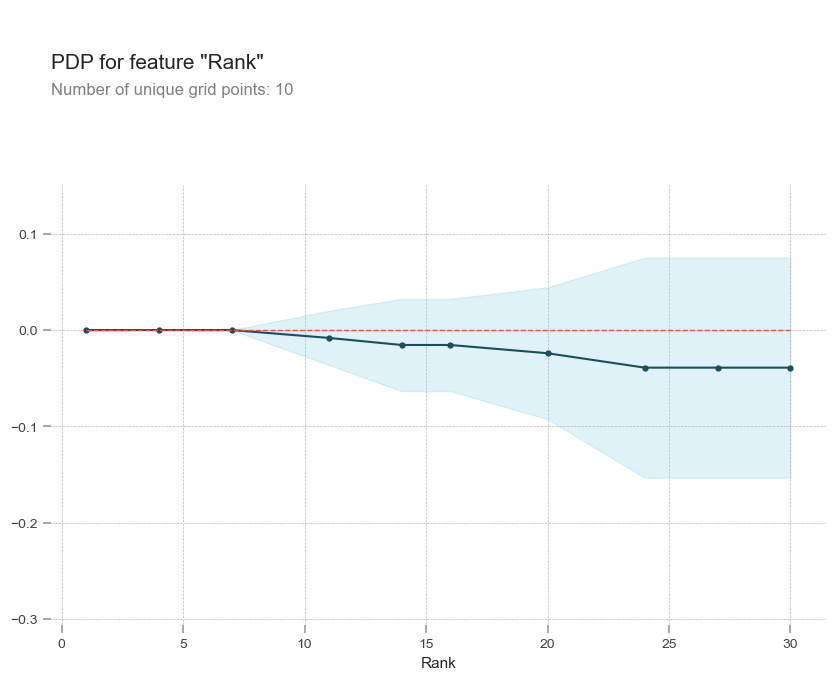

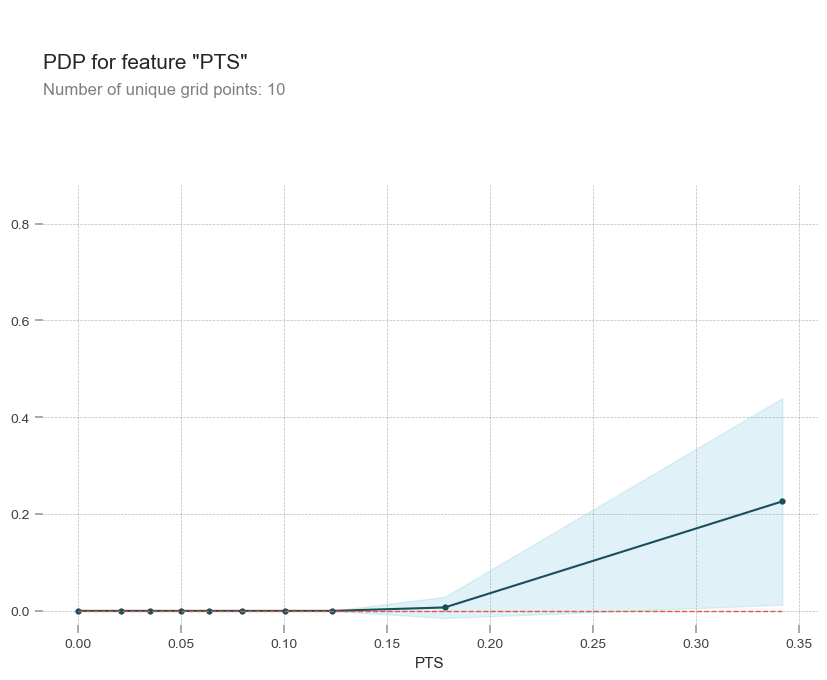

In [155]:
plot_pdp()

From Partial Dependency plots, we can see also observe that the "bump" of probability is more obvious in **PIE**, **Points** and **Rank**.

## Player-specific SHAP force plots

We can extend SHAP analysis even further, and investigate model decisions for specific players. By using force plots, we can generate personalized report for players to outline their performance and help them to improve themselves. 

These are most insightful for edge cases (who didn't been selected as All-NBA Team members), we can compare them with those who are selected as All-NBA Team members. Besides, we can also see why players like Chris Paul are not receiving have probability.

We are going to look at Guards. 

There are 6 All-NBA Team guards selected plus 2 guards who are not selected.

- 1st Team: James Harden, Luka Doncic
- 2nd Team: Chris Paul, Damian Lillard
- 3rd Team: Russell Westbrook, Ben Simmons
- Unselected Candidate: Kyrie Irving, Devin Booker

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


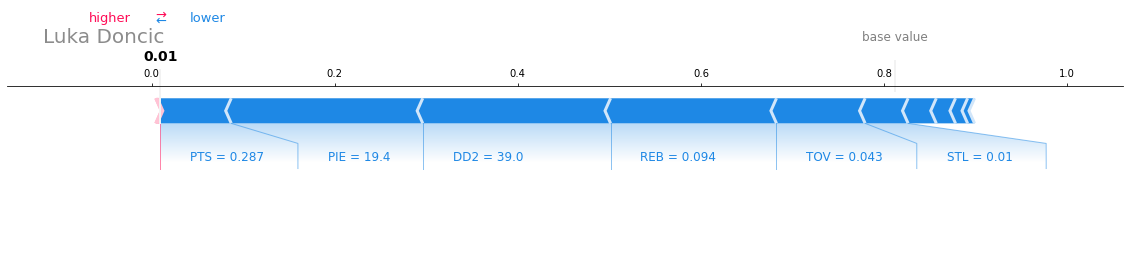

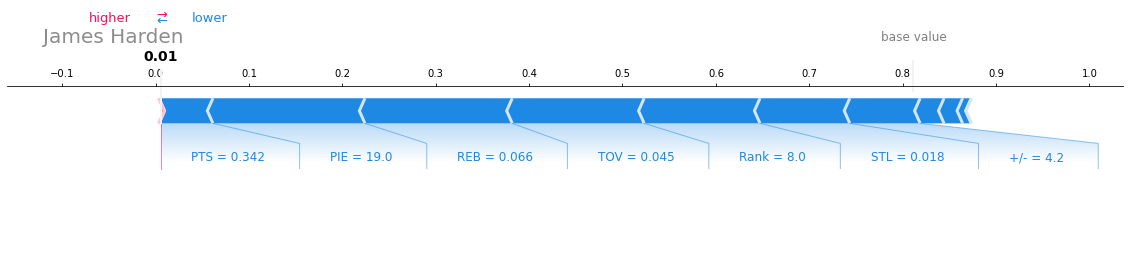

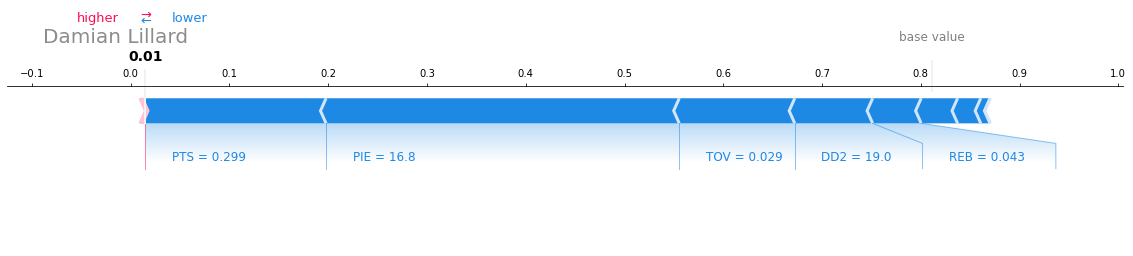

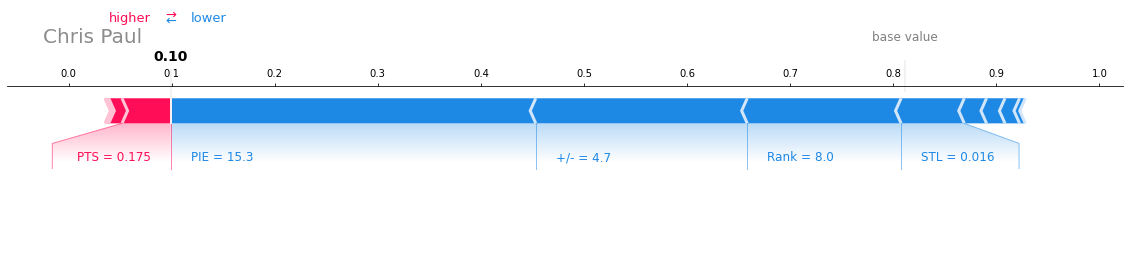

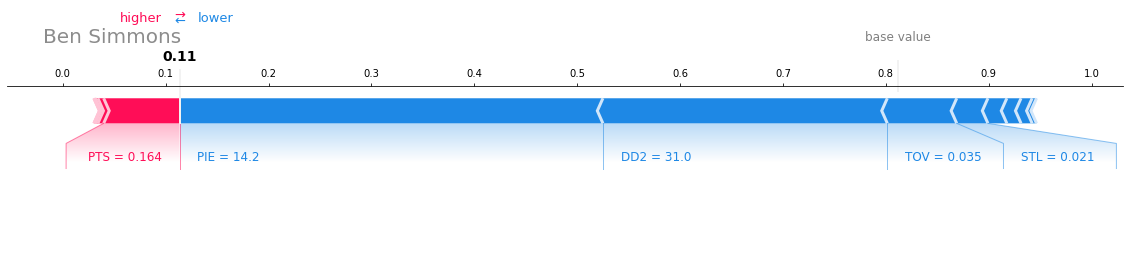

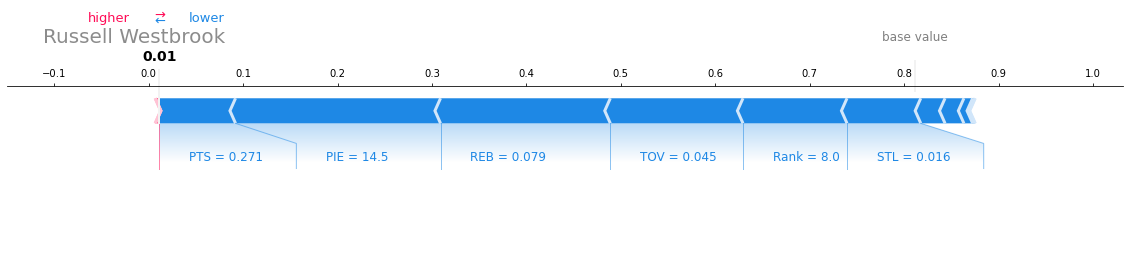

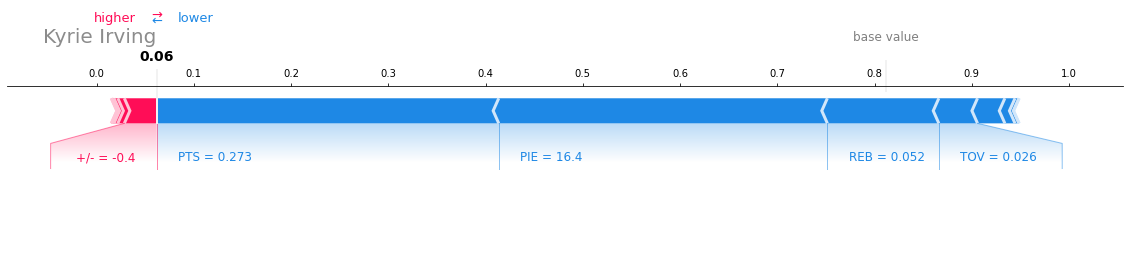

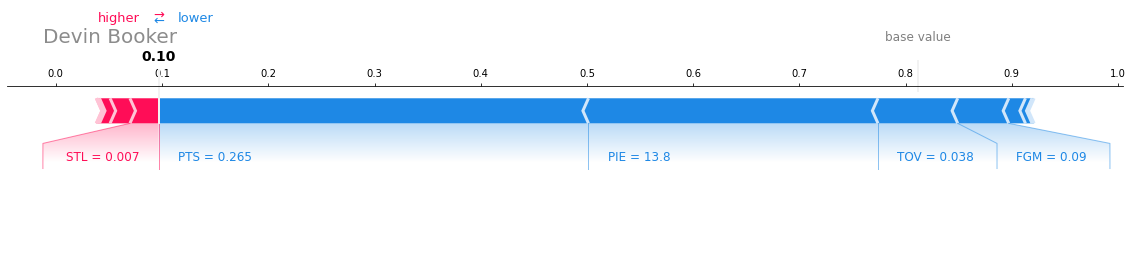

In [55]:
players_to_investigate = ['Luka Doncic', 
                          'James Harden', 
                          'Damian Lillard', 
                          'Chris Paul', 
                          'Ben Simmons', 
                          'Russell Westbrook', 
                          'Kyrie Irving', 
                          'Devin Booker']

model = pickle.load(open('A_NBA_Team_predictor.model', 'rb'))
explainer = shap.TreeExplainer(model)

# if true, will display the html/js rendering of the shap force plot
# otherwise, the matplotlib version will be displayed
disp_html = False

if disp_html:
    shap.initjs()

for i in range(len(players_to_investigate)):
    
    player_name = players_to_investigate[i]
    df_investigation = (test_data[test_data['PLAYER'] == player_name])[selected_features]
    
    # fix issue where way too many digits of each feature was being displayed in the matplotlib plot
    df_investigation = round(df_investigation, 3)
    
    player_shap_values = explainer.shap_values(np.asarray(df_investigation).reshape(1, -1))

    
    fig = shap.force_plot(explainer.expected_value[0], player_shap_values[0], df_investigation,
                    link='logit', out_names = '', feature_names=selected_features,
                    show=False, matplotlib=True)
    fig.suptitle(player_name, x=0.15, y=1.15, color='#8c8c8c', va='top', ha='left', size=20)
    
    if not disp_html:
        plt.show()
        
    plt.close()

In [59]:
df_investigation = (test_data[test_data['PLAYER'] == 'Devin Booker'])[selected_features]
df_investigation

,PTS,REB,AST,TOV,STL,BLK,Rank,FGM,DD2,NETRTG,USG%,PIE,+/-,Selected Last Year?
148,0.265204,0.041874,0.064806,0.037886,0.006979,0.002991,16,0.089731,11,2.7,29.4,13.8,1.9,0


From these plots, we gain some insights. 
1. Chris Paul and Ben Simmons are dragged down because of their scoring ability.

This is quite understandable. Scoring ability is the most straightforward way to evaluate a player. When all these players receive a high probability of being All NBA Team members, such great disadvantage will definitely influence the model prediction.

Besides, We can see that the number of Double Double is actually beneficial to Ben Simmons. In this year, the number of getting double double and triple double will change people's view to a player. From this perspective, it is supportive that DD should be selected as one of the model features. Maybe next time we should try to put Triple Double inside the model (I didn't select it this time is because it is overlapped with DD).

If we want to discuss the reason of selected doesn't be consider by the model, then there are two.

First, the model do not have a criteria to estimate the defense ability. Although Offense ability are much more important than Defense ability in NBA, we cannot ignore this. Both Ben Simmons and Chris Paul are great defensive player.

Second, the model do not have a criteria to standardize the impact for a player to one team, especially after they encounter some new challenge (e.g. the leave of another star player, or influence to a new team). Chris Paul was traded from Rocket to Thunder. At the beginning of the season, most of people underestimate Chris Paul's ability to lead this team. They all believe Thunder would tank in this year, but Chris Paul broke those prejudice by leading the team back to playoff. This is his leading ability, his way to influence a team. This kind of ability is supposed to be considered in model features.

2. Devin Booker and Kyrie Irving should lead the team further and play more efficiently.

Devin Booker and Kyrie Irving cannot receive a higher probability because they don't have sufficient advantage compared to others. As pure attackers, it is acceptable to have fewer assist or rebound compared to other guards. However, they should know how to play more efficiently and lead the team further. Both of them are having low +/- values and team rank compared to other guards. 

# Conclusion

This entire project stemmed from curiosity. As a NBA fan, it is always excited to know who are the greatest player in each year. But throughout this year, after becoming a data scientist, the curiosity ultimately pushed me to try tearing apart the selection process and gain some insights. 

This project served as a great learning experience for me. Personally, this is the first time I deal with such a challenging web scraping. In addition, this is also the first time try to break down the "black box" of complex but outstanding machine learning model. Self-learning new things and redo a complete data science project really give me a lot of fun. 

**Thank you for taking time to read this long notebook!**